# Importers

In [16]:
import matplotlib.pyplot as plt
import joblib
import numpy as np

import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score,f1_score,recall_score,balanced_accuracy_score,classification_report,ConfusionMatrixDisplay


from utils.load_data import load_data_train, load_data_test

# Loading data

In [2]:
X_train,y_train = load_data_train()
X_test,y_test = load_data_test()

In [ ]:
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()


In [ ]:

bagging_dt = BaggingClassifier(base_estimator=dt, n_estimators=3)
bagging_rf = BaggingClassifier(base_estimator=rf, n_estimators=3)

# fit the bagging classifiers on the training data
bagging_dt.fit(X_train, y_train)
joblib.dump(bagging_dt,"bagging_dt.joblib")
bagging_rf.fit(X_train, y_train)
joblib.dump(bagging_rf,"bagging_rf.joblib")





In [4]:
bagging_rf = joblib.load("bagging_rf.joblib")
bagging_dt = joblib.load("bagging_dt.joblib")

# Deriving results from the test dataset

In [5]:
y_pred_dt = bagging_dt.predict(X_test)
y_pred_rf = bagging_rf.predict(X_test)

# compute the bagged prediction by averaging the predictions from the two bagging classifiers
bag_pred = (y_pred_dt + y_pred_rf) / 2


In [9]:
bag_pred = (bag_pred >= 0.5).astype(int)

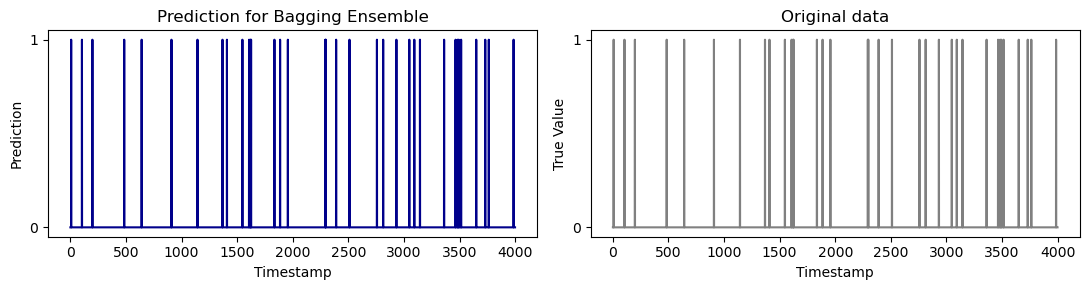

<Figure size 1100x300 with 0 Axes>

In [13]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = (11,3)

# First plot
plt.subplot(1,2,1)
plt.title("Prediction for Bagging Ensemble")
plt.plot(np.arange(len(bag_pred[19000:23000])),bag_pred[19000:23000],color="darkblue")
plt.xlabel("Timestamp")
plt.ylabel("Prediction")
plt.yticks([0.0, 1.0])

# Second plot
plt.subplot(1,2,2)
plt.title("Original data")
plt.plot(np.arange(len(y_test[19000:23000])),y_test[19000:23000],color="grey")
plt.xlabel("Timestamp")
plt.ylabel("True Value")
plt.yticks([0.0, 1.0])

plt.tight_layout()
plt.show()
plt.savefig('Bagging_ensemble.png')

# Confusion Matrix

90.0


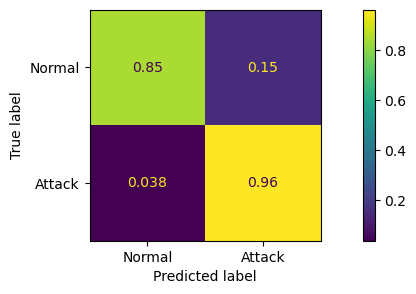

In [14]:
model_cm =confusion_matrix(y_test, bag_pred,normalize='true')

y_acc = accuracy_score(y_test, bag_pred)
y_f1score = f1_score(y_test, bag_pred)
y_recall = recall_score(y_test, bag_pred)
y_bal = balanced_accuracy_score(y_test, bag_pred)
print(round(balanced_accuracy_score(y_test, bag_pred),2)*100)

disp = ConfusionMatrixDisplay(confusion_matrix=model_cm, display_labels = ["Normal","Attack"])
disp.plot()


# Classification Report

In [15]:
print(classification_report(y_test, bag_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.85      0.91   1560065
         1.0       0.59      0.96      0.73    363663

    accuracy                           0.87   1923728
   macro avg       0.79      0.90      0.82   1923728
weighted avg       0.91      0.87      0.88   1923728



# Contribution of weights from the base models in Bagging Ensemble

In [7]:

dt_contrib_all = np.mean([estimator.feature_importances_ for estimator in bagging_dt.estimators_], axis=0)
rf_contrib_all = np.mean([estimator.feature_importances_ for estimator in bagging_rf.estimators_], axis=0)

# Compute the weights based on feature importances
dt_weight = np.sum(dt_contrib_all) / (np.sum(dt_contrib_all) + np.sum(rf_contrib_all))
rf_weight = 1 - dt_weight

print("Weight of Decision Tree:", dt_weight)
print("Weight of Random Forest:", rf_weight)


Weight of Decision Tree: 0.5
Weight of Random Forest: 0.5


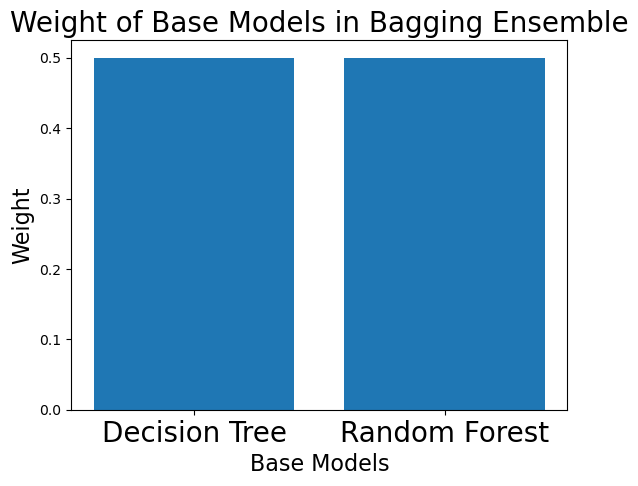

In [8]:

models = ['Decision Tree', 'Random Forest']
weights = [dt_weight, rf_weight]

plt.bar(range(len(weights)),weights)
plt.xlabel(('Base Models'),fontsize=16)
plt.ylabel(('Weight'),fontsize=16)
plt.xticks(range(len(models)), models, fontsize=20)

plt.title(('Weight of Base Models in Bagging Ensemble'),fontsize=20)
plt.show()


# Creating the dynamic plot for binary prediction

In [10]:
random_values = np.random.choice(bag_pred, size=1000, replace=False)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import imageio



# Define the window size
window_size = 100

# Create the initial plot
fig, ax = plt.subplots()
line, = ax.plot(random_values[:window_size])


# Initialize the GIF writer
with imageio.get_writer('ensemble.gif', mode='I') as writer:
    # Update the plot for each new data point
    for i in range(window_size, len(random_values)):
        line.set_ydata(random_values[i-window_size:i])
        ax.set_ylim([random_values[i-window_size:i].min(), random_values[i-window_size:i].max()])
        plt.draw()
        plt.pause(0.001)

        # Add the current plot to the GIF
        fig.canvas.draw()
        image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
        image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        writer.append_data(image)
